In [1]:
# Define paths
import sys
sys.path.append('..')

training_path = '../data/training_data/'
verification_path = '../data/verification_data/'
results_path = 'results'
interpolating_for = 'sin'

In [12]:
# Define RBF utilities (1D)
import numpy as np

def rbf_function(radius: np.ndarray, eps: float):
    return (1 + eps**2 * radius**2) ** .5

def get_rbf_matrix(interpolation_points: np.ndarray, centers: np.ndarray, eps: float = 0.1) -> np.ndarray:
    rbf_matrix = np.zeros(shape = (centers.shape[0], centers.shape[0]))
    for row_index in range(centers.shape[0]):
        rbf_matrix[row_index, :] = rbf_function(radius = np.abs(interpolation_points[row_index] - centers),
                                                 eps = eps)
    return rbf_matrix

from typing import Callable
def get_rbf_interpolant(interpolation_points: np.ndarray, centers: np.ndarray, 
                        interpolation_targets: np.ndarray, eps: float = 0.1) -> Callable:
    matrix = get_rbf_matrix(interpolation_points, centers, eps)
    coefficients = np.linalg.solve(matrix, interpolation_targets)
    # coefficients = np.matmul(np.linalg.inv(matrix), interpolation_targets)
    def fn(x: float):
        return np.dot(rbf_function(radius = np.abs(x - centers), eps = eps), coefficients)
    return fn

In [16]:
import pandas as pd

verification_data = pd.read_csv(f"{verification_path}/verification_{interpolating_for}_linspace_{10000}.csv")
epsilons = [1e-2, .25e-1, .5e-1, 1, 2, 4, 8, 16, 32]

# Task 1 - Interpolate

In [17]:
input_data = pd.read_csv(f"{training_path}input_{interpolating_for}_{16}_stepped.csv")
x = input_data['x'].to_numpy()
y = input_data['y'].to_numpy()

In [18]:
for eps in epsilons:
    print(eps)
    interpolator = get_rbf_interpolant(x, x, y, eps)

    interpolations = []
    for point_index in verification_data['x']:
        interpolations += [interpolator(point_index)]

    pd.DataFrame(data = { 'x': verification_data['x'],
                'y_target': verification_data['y'], 
                'interpolation': interpolations })\
        .to_csv(f'{results_path}/training_performance_{interpolating_for}_eps{str(eps)}_stepped_LSQ.csv',
                index=False)

0.01
0.025
0.05
1
2
4
8
16
32


# Task 2 - Evaluate interpolation performance

## 2.1 - Informal comparison

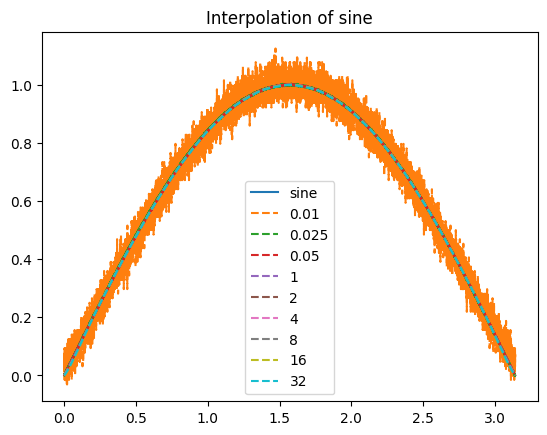

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(verification_data['x'], verification_data['y'], label = 'sine')
file_path = f'training_performance_{interpolating_for}_eps'
for eps in epsilons:
    df = pd.read_csv(f'{results_path}/{file_path}{str(eps)}_stepped_LSQ.csv')
    plt.plot(df['x'], df['interpolation'], label = f'{eps}', linestyle='--')
plt.legend()
plt.title('Interpolation of sine')
plt.show()

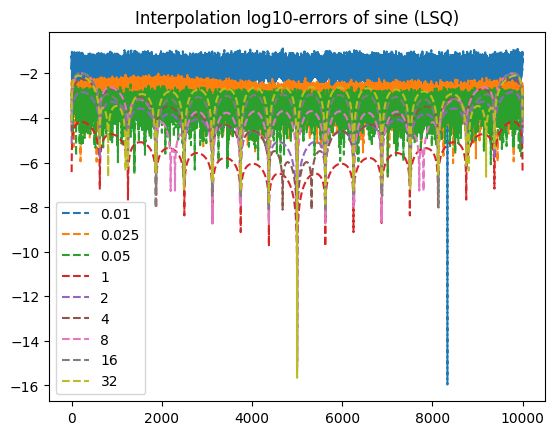

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

with np.errstate(divide='ignore'): # ignore cases when division by zero appears
    for eps in epsilons:
        df = pd.read_csv(f'{results_path}/training_performance_{interpolating_for}_eps{eps}_stepped_LSQ.csv')
        errors_list = np.log10(np.abs(df['y_target'].to_numpy() - df['interpolation'].to_numpy()))
        plt.plot(errors_list, label = f'{eps}', linestyle='--')
    plt.legend()
    plt.title('Interpolation log10-errors of sine (LSQ)')
    plt.show()

Text(0, 0.5, 'RMSE (log10)')

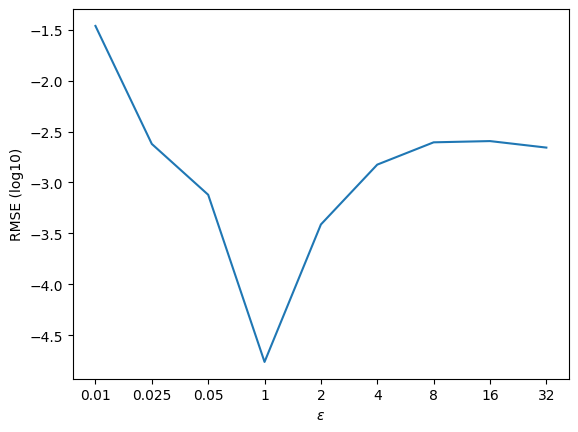

In [29]:
import matplotlib.pyplot as plt

errors_list = []
for eps in epsilons:
    df = pd.read_csv(f'{results_path}/training_performance_{interpolating_for}_eps{eps}_stepped_LSQ.csv')
    errors_list += [np.log10(np.sqrt(np.sum(np.abs(df['y_target'].to_numpy() - df['interpolation'].to_numpy()) ** 2) / 1e4))]

plt.plot([str(eps) for eps in epsilons], errors_list)
plt.xlabel('$\epsilon$')
plt.ylabel('RMSE (log10)')